## Homework 1:

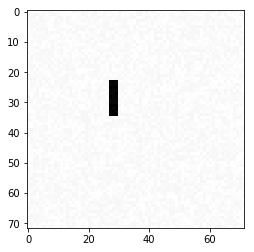

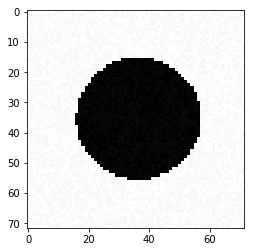

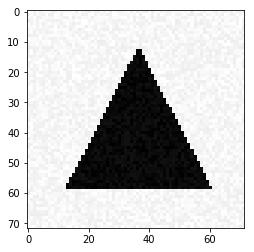

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]


def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = keras.utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


### 1.1 Simple Classification

In [2]:
X_train, Y_train = generate_dataset_classification(300, 20 , False)
X_test, Y_test = generate_dataset_classification(100, 20 , False)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90


In [3]:
%%capture
import keras
from keras.models import Sequential
from keras.layers import Dense , Activation
from keras.callbacks import History

Train on 300 samples, validate on 100 samples
Epoch 1/100
300/300 [==============================] - 8s 26ms/step - loss: 1.1168 - acc: 0.4300 - val_loss: 1.0339 - val_acc: 0.4500
Epoch 2/100
300/300 [==============================] - 0s 266us/step - loss: 0.9817 - acc: 0.4700 - val_loss: 0.9297 - val_acc: 0.4800
Epoch 3/100
300/300 [==============================] - 0s 223us/step - loss: 0.9042 - acc: 0.6000 - val_loss: 0.9119 - val_acc: 0.6000
Epoch 4/100
300/300 [==============================] - 0s 222us/step - loss: 0.8313 - acc: 0.7000 - val_loss: 0.8918 - val_acc: 0.5700
Epoch 5/100
300/300 [==============================] - 0s 233us/step - loss: 0.8146 - acc: 0.6267 - val_loss: 0.9718 - val_acc: 0.6000
Epoch 6/100
300/300 [==============================] - 0s 238us/step - loss: 0.7517 - acc: 0.7067 - val_loss: 0.7618 - val_acc: 0.5800
Epoch 7/100
300/300 [==============================] - 0s 256us/step - loss: 0.6892 - acc: 0.7400 - val_loss: 0.6927 - val_acc: 0.8100
Epoch 8/10

Epoch 61/100
300/300 [==============================] - 0s 236us/step - loss: 0.2536 - acc: 0.9700 - val_loss: 0.2725 - val_acc: 0.9700
Epoch 62/100
300/300 [==============================] - 0s 299us/step - loss: 0.2509 - acc: 0.9767 - val_loss: 0.2688 - val_acc: 0.9800
Epoch 63/100
300/300 [==============================] - 0s 271us/step - loss: 0.2508 - acc: 0.9733 - val_loss: 0.2827 - val_acc: 0.8800
Epoch 64/100
300/300 [==============================] - 0s 225us/step - loss: 0.2508 - acc: 0.9667 - val_loss: 0.2970 - val_acc: 0.8700
Epoch 65/100
300/300 [==============================] - 0s 311us/step - loss: 0.2538 - acc: 0.9500 - val_loss: 0.2620 - val_acc: 0.9800
Epoch 66/100
300/300 [==============================] - 0s 222us/step - loss: 0.2461 - acc: 0.9600 - val_loss: 0.2621 - val_acc: 0.9600
Epoch 67/100
300/300 [==============================] - 0s 222us/step - loss: 0.2396 - acc: 0.9733 - val_loss: 0.2663 - val_acc: 1.0000
Epoch 68/100
300/300 [==========================

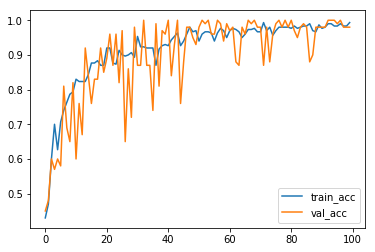

In [4]:
#Training Parameters 
lr = 0.001
epochs = 100
batch_size = 32

#Callbacks
history = History()

ny_train = keras.utils.to_categorical(Y_train) # We adapt the data
ny_test = keras.utils.to_categorical(Y_test)


# Model
model = Sequential()
model.add(Dense(ny_train.shape[1] , input_shape = (X_train.shape[1],) ))
model.add(Activation('softmax'))

optimizer = keras.optimizers.SGD(lr = lr)

model.compile(loss='categorical_crossentropy', optimizer= optimizer , metrics = ['accuracy'])
model.fit(X_train, ny_train, epochs= epochs, validation_data = [X_test , ny_test],
          batch_size=batch_size, callbacks = [history])

plt.plot(history.history['acc'] , label = 'train_acc')
plt.plot(history.history['val_acc'] , label= 'val_acc')
plt.legend()
plt.show()

Train on 300 samples, validate on 100 samples
Epoch 1/100
300/300 [==============================] - 0s 1ms/step - loss: 1.3053 - acc: 0.2600 - val_loss: 1.1339 - val_acc: 0.2600
Epoch 2/100
300/300 [==============================] - 0s 240us/step - loss: 1.0860 - acc: 0.4567 - val_loss: 1.0220 - val_acc: 0.5200
Epoch 3/100
300/300 [==============================] - 0s 357us/step - loss: 0.9496 - acc: 0.5500 - val_loss: 0.9212 - val_acc: 0.6400
Epoch 4/100
300/300 [==============================] - 0s 286us/step - loss: 0.8627 - acc: 0.6133 - val_loss: 0.8622 - val_acc: 0.6800
Epoch 5/100
300/300 [==============================] - 0s 274us/step - loss: 0.7963 - acc: 0.7033 - val_loss: 0.8010 - val_acc: 0.6400
Epoch 6/100
300/300 [==============================] - 0s 284us/step - loss: 0.7458 - acc: 0.6367 - val_loss: 0.7544 - val_acc: 0.7000
Epoch 7/100
300/300 [==============================] - 0s 303us/step - loss: 0.6941 - acc: 0.7533 - val_loss: 0.7147 - val_acc: 0.6800
Epoch 8/100

Epoch 61/100
300/300 [==============================] - 0s 316us/step - loss: 0.1629 - acc: 0.9967 - val_loss: 0.1937 - val_acc: 1.0000
Epoch 62/100
300/300 [==============================] - 0s 241us/step - loss: 0.1670 - acc: 1.0000 - val_loss: 0.1920 - val_acc: 0.9800
Epoch 63/100
300/300 [==============================] - 0s 227us/step - loss: 0.1627 - acc: 0.9833 - val_loss: 0.1868 - val_acc: 1.0000
Epoch 64/100
300/300 [==============================] - 0s 236us/step - loss: 0.1595 - acc: 0.9967 - val_loss: 0.1839 - val_acc: 0.9900
Epoch 65/100
300/300 [==============================] - 0s 284us/step - loss: 0.1554 - acc: 0.9933 - val_loss: 0.1781 - val_acc: 1.0000
Epoch 66/100
300/300 [==============================] - 0s 279us/step - loss: 0.1523 - acc: 0.9933 - val_loss: 0.1757 - val_acc: 1.0000
Epoch 67/100
300/300 [==============================] - 0s 329us/step - loss: 0.1496 - acc: 0.9967 - val_loss: 0.1735 - val_acc: 1.0000
Epoch 68/100
300/300 [==========================

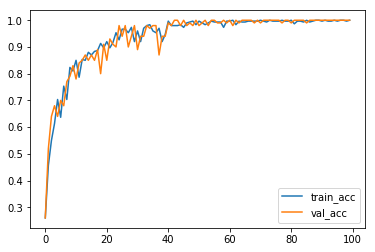

In [5]:
# Training Parameters:
lr = 0.0001
epochs = 100
history = History()

# Model
model = Sequential()
model.add(Dense(ny_train.shape[1] , input_shape = (X_train.shape[1],) ))
model.add(Activation('softmax'))

optimizer = keras.optimizers.Adam(lr = lr)

model.compile(loss='categorical_crossentropy', optimizer= optimizer , metrics = ['accuracy'])
model.fit(X_train, ny_train, epochs= epochs, validation_data = [X_test , ny_test],
          batch_size=batch_size, callbacks = [history])

plt.plot(history.history['acc'] , label = 'train_acc')
plt.plot(history.history['val_acc'] , label= 'val_acc')
plt.legend()
plt.show()

### 1.2 Visualization of the Solution

In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


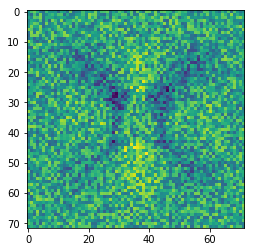

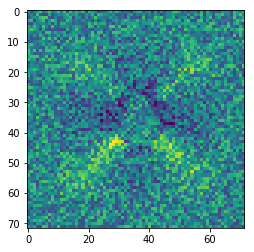

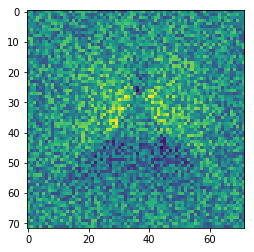

In [7]:
weights = model.get_weights()[0].T


for w in weights:
    plt.imshow(w.reshape((72 , 72)))
    plt.show()

### 1.3 A More Difficult Classification Problem


In [20]:
X_train, Y_train = generate_dataset_classification(300, 20, True)
X_test, Y_test = generate_test_set_classification()

ny_train = keras.utils.to_categorical(Y_train) # We adapt the data

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


Train on 300 samples, validate on 300 samples
Epoch 1/100
300/300 [==============================] - 1s 3ms/step - loss: 1.1374 - acc: 0.3833 - val_loss: 1.1065 - val_acc: 0.3300
Epoch 2/100
300/300 [==============================] - 0s 392us/step - loss: 1.1023 - acc: 0.3400 - val_loss: 1.1599 - val_acc: 0.3867
Epoch 3/100
300/300 [==============================] - 0s 321us/step - loss: 1.0680 - acc: 0.4933 - val_loss: 1.0605 - val_acc: 0.3667
Epoch 4/100
300/300 [==============================] - 0s 316us/step - loss: 1.0552 - acc: 0.4667 - val_loss: 1.0675 - val_acc: 0.4267
Epoch 5/100
300/300 [==============================] - 0s 389us/step - loss: 1.0233 - acc: 0.4733 - val_loss: 1.0546 - val_acc: 0.4200
Epoch 6/100
300/300 [==============================] - 0s 360us/step - loss: 0.9782 - acc: 0.5500 - val_loss: 1.0455 - val_acc: 0.4800
Epoch 7/100
300/300 [==============================] - 0s 339us/step - loss: 0.9701 - acc: 0.5767 - val_loss: 1.0229 - val_acc: 0.4733
Epoch 8/100

Epoch 61/100
300/300 [==============================] - 0s 336us/step - loss: 0.7164 - acc: 0.7067 - val_loss: 0.8561 - val_acc: 0.5633
Epoch 62/100
300/300 [==============================] - 0s 316us/step - loss: 0.7110 - acc: 0.6800 - val_loss: 0.8483 - val_acc: 0.5967
Epoch 63/100
300/300 [==============================] - 0s 349us/step - loss: 0.7153 - acc: 0.6933 - val_loss: 0.8351 - val_acc: 0.5233
Epoch 64/100
300/300 [==============================] - 0s 304us/step - loss: 0.7132 - acc: 0.6833 - val_loss: 0.9252 - val_acc: 0.5567
Epoch 65/100
300/300 [==============================] - 0s 339us/step - loss: 0.7115 - acc: 0.6967 - val_loss: 0.8324 - val_acc: 0.5567
Epoch 66/100
300/300 [==============================] - 0s 312us/step - loss: 0.7203 - acc: 0.6800 - val_loss: 0.8390 - val_acc: 0.5167
Epoch 67/100
300/300 [==============================] - 0s 438us/step - loss: 0.7024 - acc: 0.6833 - val_loss: 0.8616 - val_acc: 0.5800
Epoch 68/100
300/300 [==========================

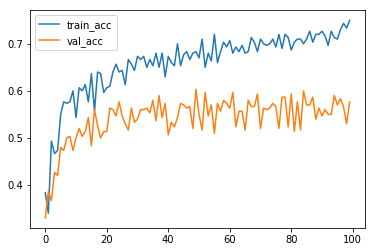

In [9]:
#Linear Model

# Training Parameters:
lr = 0.0001
epochs = 100
history = History()

# Model
model = Sequential()
model.add(Dense(ny_train.shape[1] , input_shape = (X_train.shape[1],) ))
model.add(Activation('softmax'))

optimizer = keras.optimizers.Adam(lr = lr)

model.compile(loss='categorical_crossentropy', optimizer= optimizer , metrics = ['accuracy'])
model.fit(X_train, ny_train, validation_data = [X_test, Y_test] ,epochs= epochs, batch_size=batch_size, callbacks = [history])

plt.plot(history.history['acc'] , label = 'train_acc')
plt.plot(history.history['val_acc'] , label= 'val_acc')
plt.legend()
plt.show()

The value of the loss function on the test set is :  0.5767

#### Convolutional Model :

Train on 300 samples, validate on 300 samples
Epoch 1/80
300/300 [==============================] - 1s 5ms/step - loss: 1.1545 - acc: 0.3000 - val_loss: 1.1514 - val_acc: 0.4467
Epoch 2/80
300/300 [==============================] - 0s 990us/step - loss: 1.0865 - acc: 0.4933 - val_loss: 1.0514 - val_acc: 0.4000
Epoch 3/80
300/300 [==============================] - 0s 985us/step - loss: 1.0437 - acc: 0.3800 - val_loss: 1.0227 - val_acc: 0.5600
Epoch 4/80
300/300 [==============================] - 0s 999us/step - loss: 1.0099 - acc: 0.4400 - val_loss: 1.0141 - val_acc: 0.5200
Epoch 5/80
300/300 [==============================] - 0s 989us/step - loss: 0.9503 - acc: 0.5667 - val_loss: 0.9749 - val_acc: 0.4800
Epoch 6/80
300/300 [==============================] - 0s 1ms/step - loss: 0.9240 - acc: 0.5433 - val_loss: 0.9426 - val_acc: 0.6600
Epoch 7/80
300/300 [==============================] - 0s 1ms/step - loss: 0.8766 - acc: 0.6800 - val_loss: 0.9242 - val_acc: 0.5400
Epoch 8/80
300/300 [==

Epoch 62/80
300/300 [==============================] - 0s 990us/step - loss: 0.2726 - acc: 0.9633 - val_loss: 0.6680 - val_acc: 0.6933
Epoch 63/80
300/300 [==============================] - 0s 992us/step - loss: 0.2755 - acc: 0.9700 - val_loss: 0.6695 - val_acc: 0.7100
Epoch 64/80
300/300 [==============================] - 0s 1ms/step - loss: 0.2671 - acc: 0.9700 - val_loss: 0.6683 - val_acc: 0.6967
Epoch 65/80
300/300 [==============================] - 0s 992us/step - loss: 0.2654 - acc: 0.9667 - val_loss: 0.6706 - val_acc: 0.7067
Epoch 66/80
300/300 [==============================] - 0s 1ms/step - loss: 0.2595 - acc: 0.9700 - val_loss: 0.6696 - val_acc: 0.7100
Epoch 67/80
300/300 [==============================] - 0s 990us/step - loss: 0.2689 - acc: 0.9600 - val_loss: 0.6840 - val_acc: 0.7000
Epoch 68/80
300/300 [==============================] - 0s 1ms/step - loss: 0.2602 - acc: 0.9700 - val_loss: 0.6852 - val_acc: 0.6833
Epoch 69/80
300/300 [==============================] - 0s 997

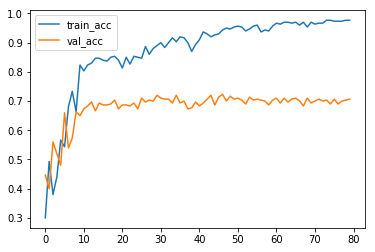

In [21]:
#Covolutional Model


from keras.layers import Conv2D, MaxPooling2D, Flatten

nX_train = X_train.reshape((300 , 72 , 72 , 1))
nX_test = X_test.reshape((300 , 72 , 72 , 1))

# Training Parameters:
lr = 0.0001
epochs = 80
history = History()

# Model
model = Sequential()
model.add(Conv2D(16 , 5 , input_shape = (72 , 72 , 1) , data_format="channels_last" ))
model.add(Activation('relu'))
model.add(MaxPooling2D(strides = 1))
model.add(Flatten())
model.add(Dense(ny_train.shape[1]) )
model.add(Activation('softmax'))

optimizer = keras.optimizers.Adam(lr = lr)

model.compile(loss='categorical_crossentropy', optimizer= optimizer , metrics = ['accuracy'])
model.fit(nX_train, ny_train, validation_data = [nX_test, Y_test] ,epochs= epochs, batch_size=batch_size, callbacks = [history])

plt.plot(history.history['acc'] , label = 'train_acc')
plt.plot(history.history['val_acc'] , label= 'val_acc')
plt.legend()
plt.show()

The value of the loss function on the test set is :  0.6751

### 1.4 A Regression Problem :

We need to rearrange the vertices in a logical way for the neural network to learn an efficient function. We choose to rearrange the edges from left to right (x axis).

In [22]:
%%capture

def rearrange(arr):
    sarr = sorted(zip(arr[[i*2 for i in range(3)]] , arr[[i*2 + 1 for i in range(3)]]))
    return np.array(sarr).flatten()

X_train, Y_train = generate_dataset_regression(10000, 20)
X_test, Y_test = generate_test_set_regression()

Y_train = np.array([rearrange(y) for y in Y_train])
Y_test = np.array([rearrange(y) for y in Y_test])

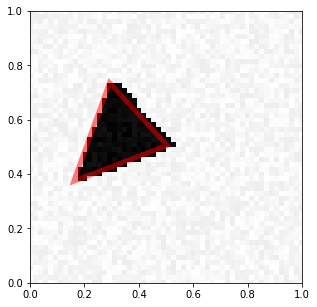

In [23]:
visualize_prediction(X_train[1], Y_train[1])

Train on 10000 samples, validate on 300 samples
Epoch 1/30
10000/10000 [==============================] - 65s 7ms/step - loss: 0.0367 - val_loss: 0.0247
Epoch 2/30
10000/10000 [==============================] - 61s 6ms/step - loss: 0.0175 - val_loss: 0.0141
Epoch 3/30
10000/10000 [==============================] - 61s 6ms/step - loss: 0.0111 - val_loss: 0.0106
Epoch 4/30
10000/10000 [==============================] - 60s 6ms/step - loss: 0.0089 - val_loss: 0.0095
Epoch 5/30
10000/10000 [==============================] - 60s 6ms/step - loss: 0.0079 - val_loss: 0.0082
Epoch 6/30
10000/10000 [==============================] - 60s 6ms/step - loss: 0.0071 - val_loss: 0.0077
Epoch 7/30
10000/10000 [==============================] - 60s 6ms/step - loss: 0.0066 - val_loss: 0.0075
Epoch 8/30
10000/10000 [==============================] - 60s 6ms/step - loss: 0.0060 - val_loss: 0.0074
Epoch 9/30
10000/10000 [==============================] - 60s 6ms/step - loss: 0.0056 - val_loss: 0.0068
Epoch 1

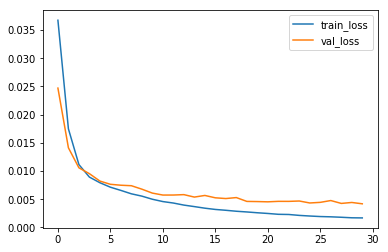

In [24]:
from keras.layers import Conv2D, MaxPooling2D, Flatten

# Model :

# Training Parameters:
lr = 0.0001
epochs = 30
batch_size = 64
history = History()

X_train = X_train.reshape((10000 , 72 , 72 , 1))
X_test = X_test.reshape((300 , 72 , 72 , 1))

# Model
model = Sequential()

model.add(Conv2D(64 , 3 , input_shape = (72 , 72 , 1) , data_format="channels_last" ))
model.add(Activation('relu'))

model.add(Conv2D(128 , 5, data_format="channels_last" ))
model.add(Activation('relu'))
model.add(MaxPooling2D(strides = 2))

model.add(Conv2D(128 , 5, data_format="channels_last" ))
model.add(Activation('relu'))
model.add(MaxPooling2D(strides = 2))


model.add(Flatten())
# model.add(Dense(32))
# model.add(Activation('relu'))
model.add(Dense(Y_train.shape[1]) )
model.add(Activation('sigmoid'))


optimizer = keras.optimizers.Adam(lr = lr)

model.compile(loss='mean_squared_error', optimizer= optimizer)
model.fit(X_train, Y_train, validation_data = [X_test, Y_test] ,epochs= epochs, batch_size=batch_size, callbacks = [history])

plt.plot(history.history['loss'] , label = 'train_loss')
plt.plot(history.history['val_loss'] , label= 'val_loss')
plt.legend()
plt.show()

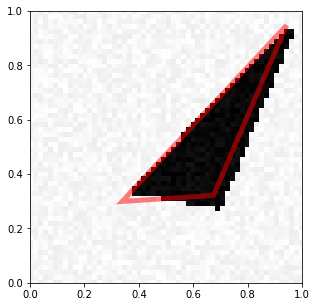

In [27]:
i = 0
visualize_prediction(X_test[i], model.predict(X_test[i].reshape(1 , 72 , 72 , 1)))

### 1.5 Image Denoising 

We use the hourglass scheme to build a network capable of Denoise the generated images :

In [15]:
def noisy(noise_typ,image):
    
    row,col= image.shape
    
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = image + gauss
    
    return noisy

def generate_noise_dataset_classification(nb_samples, noise=30, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    X_noise = np.zeros([nb_samples,im_size])
    
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        
        X_noise[i] = X[i] + np.random.normal(size = im_size)*30
        

    X_noise = (X_noise + noise) / (255 + 2*noise + 30)
    #X_noise = (X_noise - X_noise.min()) / (X_noise.max() - X_noise.min())
    X = (X + noise) / (255 + 2*noise)
    return [X_noise, X]


X_noise , X = generate_noise_dataset_classification(300, noise=10, free_location=False)
X_noise_test , X_test = generate_noise_dataset_classification(300, noise=10, free_location=False)

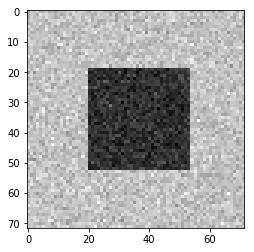

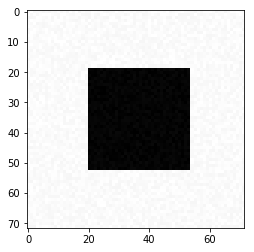

In [16]:
im = X_noise[0]
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

im = X[0]
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

Train on 300 samples, validate on 300 samples
Epoch 1/100
300/300 [==============================] - 3s 10ms/step - loss: 0.2075 - val_loss: 0.1994
Epoch 2/100
300/300 [==============================] - 1s 3ms/step - loss: 0.1937 - val_loss: 0.1861
Epoch 3/100
300/300 [==============================] - 1s 3ms/step - loss: 0.1800 - val_loss: 0.1735
Epoch 4/100
300/300 [==============================] - 1s 3ms/step - loss: 0.1672 - val_loss: 0.1616
Epoch 5/100
300/300 [==============================] - 1s 3ms/step - loss: 0.1550 - val_loss: 0.1501
Epoch 6/100
300/300 [==============================] - 1s 3ms/step - loss: 0.1431 - val_loss: 0.1390
Epoch 7/100
300/300 [==============================] - 1s 3ms/step - loss: 0.1319 - val_loss: 0.1285
Epoch 8/100
300/300 [==============================] - 1s 3ms/step - loss: 0.1210 - val_loss: 0.1188
Epoch 9/100
300/300 [==============================] - 1s 3ms/step - loss: 0.1113 - val_loss: 0.1101
Epoch 10/100
300/300 [======================

Epoch 81/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 82/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0047 - val_loss: 0.0048
Epoch 83/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 84/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 85/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 86/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0047
Epoch 87/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0047
Epoch 88/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 89/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0044 - val_loss: 0.0046
Epoch 90/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0044

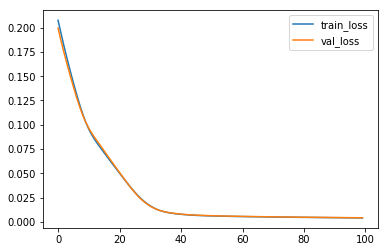

In [17]:
# Model :
from keras.layers import UpSampling2D

# Training Parameters:
lr = 0.0001
epochs = 100
batch_size = 64
history = History()

X_noise =X_noise.reshape((300 , 72 , 72 , 1))
X_noise_test =X_noise_test.reshape((300 , 72 , 72 , 1))

X =X.reshape((300 , 72 , 72 , 1))
X_test =X_test.reshape((300 , 72 , 72 , 1))


# Model
model = Sequential()
model.add(Conv2D(16 , 3 , input_shape = (72 , 72 , 1) , data_format="channels_last" , padding = 'same' ))
model.add(MaxPooling2D(strides = (2,2)))
model.add(Activation('relu'))

model.add(Conv2D(32 , 3 , data_format="channels_last" , padding = 'same' ))
model.add(MaxPooling2D(strides = (2,2)))
model.add(Activation('relu'))

# REVERSE

model.add(UpSampling2D(size = (2,2)))
model.add(Conv2D(32 , 3 , data_format="channels_last" ,padding = 'same' ))
model.add(Activation('relu'))

model.add(UpSampling2D(size = (2,2)))
model.add(Conv2D(1 , 5  , data_format="channels_last" , padding = 'same'))
model.add(Activation('sigmoid'))










optimizer = keras.optimizers.Adam(lr = lr)
model.compile(loss='mean_squared_error', optimizer= optimizer)
model.fit(X_noise, X, validation_data = [X_noise_test, X_test] ,epochs= epochs, batch_size=batch_size, callbacks = [history])

plt.plot(history.history['loss'] , label = 'train_loss')
plt.plot(history.history['val_loss'] , label= 'val_loss')
plt.legend()
plt.show()

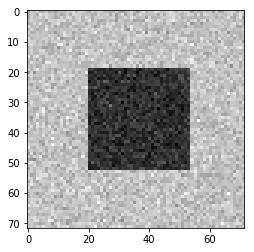

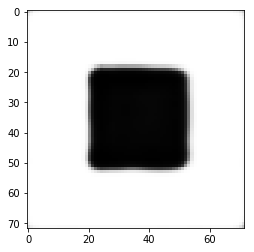

In [19]:
im = X_noise[0]
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

im = model.predict(X_noise[:1])
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()